<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Convert-Label-Studio-CSV-to-Huggingface-autoTrain-Token-Classification-Training-File" data-toc-modified-id="Convert-Label-Studio-CSV-to-Huggingface-autoTrain-Token-Classification-Training-File-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Convert Label-Studio CSV to Huggingface autoTrain Token Classification Training File</a></span></li><li><span><a href="#Define-Predict-Function-Using-Trained-Model-From-AutoTrain-Huggingface-Returns-Dictionary-With-Data" data-toc-modified-id="Define-Predict-Function-Using-Trained-Model-From-AutoTrain-Huggingface-Returns-Dictionary-With-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Predict Function Using Trained Model From AutoTrain Huggingface Returns Dictionary With Data</a></span></li><li><span><a href="#Make-list_of_predictions-using-HuggingFace-autoTrain-model" data-toc-modified-id="Make-list_of_predictions-using-HuggingFace-autoTrain-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Make list_of_predictions using HuggingFace autoTrain model</a></span></li><li><span><a href="#Interactively-Curate-True-and-Falsified-Predictions-and-store-to-joblib-file" data-toc-modified-id="Interactively-Curate-True-and-Falsified-Predictions-and-store-to-joblib-file-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Interactively Curate True and Falsified Predictions and store to joblib file</a></span></li><li><span><a href="#Backtest-agaist-real-data" data-toc-modified-id="Backtest-agaist-real-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Backtest agaist real data</a></span></li><li><span><a href="#Listen-to-Telegram-Channel-for-messages-and-predict-tokens" data-toc-modified-id="Listen-to-Telegram-Channel-for-messages-and-predict-tokens-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Listen to Telegram Channel for messages and predict tokens</a></span></li><li><span><a href="#Supplimentry-Functions" data-toc-modified-id="Supplimentry-Functions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Supplimentry Functions</a></span></li></ul></div>

Tested on   
python3.8  
pandas-1.5.0  

TODO:  
1 : make pytohn api for web interaction    
2 : test against other groups data than ratnakar  

# Convert Label-Studio CSV to Huggingface autoTrain Token Classification Training File

In [ ]:
import pandas as pd
import ast
from tqdm import  tqdm
import math
import re
import numpy as np
import ipywidgets as widgets
from functools import partial
from IPython.display import clear_output
import joblib
import telegramAuth

##### Load Local saved Label-studio CSV export file

In [ ]:
# pip install joblib

In [ ]:
csv_import = pd.read_csv('./project-1-at-2022-09-19-18-31-ecd4d830.csv')
csv_import.head()

,text,id,label,annotator,annotation_id,created_at,updated_at,lead_time
0,INTRADAY : BUY M&MFIN CMP 189.25 SL 187 TARGET...,1137,"[{""start"": 0, ""end"": 8, ""text"": ""INTRADAY"", ""l...",1,1143,2022-09-15T20:34:16.930865Z,2022-09-15T20:34:16.930928Z,16.611
1,WATCHOUT.. TOKYOPLAST... GOING UP.... TOUCHED ...,1136,"[{""start"": 11, ""end"": 21, ""text"": ""TOKYOPLAST""...",1,1142,2022-09-15T20:33:58.815115Z,2022-09-15T20:33:58.815174Z,8.208
2,WATCHOUT... ABOVE 95 IT TOUCHED 101.70.. NEAR ...,1135,"[{""start"": 18, ""end"": 20, ""text"": ""95"", ""label...",1,1141,2022-09-15T20:33:41.581882Z,2022-09-15T20:33:41.581940Z,19.453
3,INTRADAY : BUY JYOTHYLAB CMP 161 SL 158 TARGET...,1134,"[{""start"": 0, ""end"": 8, ""text"": ""INTRADAY"", ""l...",1,1140,2022-09-15T20:33:20.613625Z,2022-09-15T20:33:20.613684Z,23.483
4,JYOTHYLAB IS VERY GOOD FOR DELIVERY ALSO STRI...,1133,"[{""start"": 0, ""end"": 9, ""text"": ""JYOTHYLAB"", ""...",1,1139,2022-09-15T20:32:55.622748Z,2022-09-15T20:32:55.622787Z,16.428


In [ ]:
# convert_label_studio_to_hngFace_autoTrain_dataset(csv_import)

In [ ]:
def NEW_LOGIC_convert_label_studio_to_hngFace_autoTrain_dataset(csv_import) -> list:
    '''Converts export file from Label-Studio to HuggingFace autoTrain trainable dataset
    Example : 
    
    *****   INPUT of this function  **** (file : ../project-1-at-2022-09-13-06-14-0f0c0db3.csv))
    text	id	annotator	annotation_id	created_at	updated_at	lead_time	label
    KEEP   JAGSNPHARM ON RADAR... 	1001	1	1007	2022-09-13T05:51:47.578986Z	2022-09-13T05:51:47.579052Z	4.298	[{"start": 7, "end": 17, "text": "JAGSNPHARM", "labels": ["symbol"]}]
    INTRADAY : BUY JAGSNPHARM ABOVE 306 SL 302 TARGET 312 - 316 - 320 	1000	1	1006	2022-09-13T05:51:41.795524Z	2022-09-13T05:51:41.795587Z	6.055	[{"start": 15, "end": 25, "text": "JAGSNPHARM", "labels": ["symbol"]}, {"start": 32, "end": 35, "text": "306", "labels": ["enter"]}, {"start": 39, "end": 42, "text": "302", "labels": ["sl"]}, {"start": 50, "end": 53, "text": "312", "labels": ["exit"]}]
    SUPER DUPER FUNDAMENTALS IN JAGSNPHARM... 	999	1	1005	2022-09-13T05:51:34.283369Z	2022-09-13T05:51:34.283431Z	2.903	[{"start": 28, "end": 38, "text": "JAGSNPHARM", "labels": ["symbol"]}]
    
    *****   OUTPUT of this function  **** (file : ./dataset_for_huggingface_autoTrain_label_vlassification.csv)
    text	label
    ['KEEP   ', 'JAGSNPHARM', ' ON RADAR... ']	['NANA', 'symbol', 'NANA']
    ['INTRADAY : BUY ', 'JAGSNPHARM', ' ABOVE ', '306', ' SL ', '302', ' TARGET ', '312', ' - 316 - 320 ']	['NANA', 'symbol', 'NANA', 'enter', 'NANA', 'sl', 'NANA', 'exit', 'NANA']
    ['JAGSNPHARM', '... ']	['symbol', 'NANA']
    '''
    
    final_dataset = []
    for indx in csv_import.index:
        this_label = csv_import.label[indx]
        this_test_str = ''

    #     print(f'{indx=}')
    #     print(f'{this_label=}')

    #     print(f'{type(this_test_str)=}')
    #     print(f'{type(this_label)=}')

        if(type(this_test_str) != type(this_label)):
            if(np.isnan(this_label)):
                final_dataset.append({'text':'','label':'NANA'})
                continue

        this_literal_list = ast.literal_eval(this_label)

        start_pos_of_label__list = []
        for ipdata in this_literal_list:
            start_pos_of_label__list.append(ipdata['start'])
        start_pos_of_label__list
        start_pos_of_label__array = np.array(start_pos_of_label__list)
        sort_index = np.argsort(start_pos_of_label__array)
    #     print(start_pos_of_label__array)
    #     print(sort_index)

        this_text = csv_import.text[indx]

        final_label_text = []
        final_label_annotation = []
        init_labeling = True
        last_end_position = 0
        for i in sort_index:
        #     print(this_literal_list[i])
            this_label_type = this_literal_list[i]['labels'][0]
        #     print(f'{this_label_type=}')
            this_label_start_position = this_literal_list[i]['start']
            this_label_end_position = this_literal_list[i]['end']
        #     print(f'{this_label_start_position=}')
        #     print(f'{this_label_end_position=}')
        #     print(f'{this_text=}')
        #     print(f'{this_text[this_label_start_position:this_label_end_position]=}')
        #     print()

            if(init_labeling & this_label_start_position!=0):
                final_label_text.append(this_text[0:this_label_start_position])
                final_label_annotation.append('NANA')

            final_label_text.append(this_text[this_label_start_position:this_label_end_position])
            final_label_annotation.append(this_label_type)

            if((i)<sort_index[-1]):
                next_word_start_position = this_literal_list[i+1]['start']
                if(this_label_end_position!=next_word_start_position):
                    final_label_text.append(this_text[this_label_end_position:next_word_start_position])
                    final_label_annotation.append('NANA')


            last_end_position=this_label_end_position
        #     print('==debug==')
        #     print(f'{i=}')
        #     print(f'{sort_index[-1]=}')
        #     print(f'{this_label_end_position=}')
        #     print(f'{len(this_text)=}')
        #     print(f'{((i==sort_index[-1]) and this_label_end_position<len(this_text))=}')
        #     print('==debug==')

            if((i==sort_index[-1]) and this_label_end_position<len(this_text)):
                final_label_text.append(this_text[this_label_end_position:])
                final_label_annotation.append('NANA')


            init_labeling = False
        #     break

        # print('--------------------')
    #     display(f'{final_label_text=}')
    #     display(f'{final_label_annotation=}')

        final_dataset.append({'text':final_label_text,'label':final_label_annotation})
    return final_dataset

In [ ]:
# this_dataset_df = pd.DataFrame(NEW_LOGIC_convert_label_studio_to_hngFace_autoTrain_dataset(csv_import))
# this_dataset_df.to_csv('./dataset_for_huggingface_autoTrain_label_vlassification_NEW_LOGIC.csv',index=False)
# this_dataset_df

In [ ]:
# 192.168.227.62 - - [19/Sep/2022 18:09:36] "GET /api/jobs/65320ac73a4847a2b5a7f8ddbd45b821 HTTP/1.1" 200 -
# 2022-09-19 18:09:37 sparsify.blueprints.jobs INFO     getting job 65320ac73a4847a2b5a7f8ddbd45b821
# 2022-09-19 18:09:37 sparsify.blueprints.jobs INFO     retrieved job {'job': {'created': '2022-09-19T18:09:22.636614', 'worker_args': {'model_id': '5f276c2809654a24adb8d4ed4c3da3d7', 'profile_id': '4cbcefb9e2fe4a3fa7903604f72ea5a3', 'batch_size': 10, 'core_count': 8, 'pruning_estimations': True, 'quantized_estimations': False, 'iterations_per_check': 10, 'warmup_iterations_per_check': 5}, 'modified': '2022-09-19T18:09:36.205104', 'type_': 'CreatePerfProfileJobWorker', 'error': None, 'project_id': 'e1852305571c4f138149d12312acc30d', 'job_id': '65320ac73a4847a2b5a7f8ddbd45b821', 'progress': None, 'status': 'started'}}
# 192.168.227.62 - - [19/Sep/2022 18:09:37] "GET /api/jobs/65320ac73a4847a2b5a7f8ddbd45b821 HTTP/1.1" 200 -
# 2022-09-19 18:09:37 sparsify.workers.manager WARNING  Job 65320ac73a4847a2b5a7f8ddbd45b821 errored out Invalid input shape, cannot create a random input shape from: (None,)
# 2022-09-19 18:09:37 sparsify.blueprints.jobs INFO     getting job 65320ac73a4847a2b5a7f8ddbd45b821
# 2022-09-19 18:09:37 sparsify.blueprints.jobs INFO     retrieved job {'job': {'created': '2022-09-19T18:09:22.636614', 'worker_args': {'model_id': '5f276c2809654a24adb8d4ed4c3da3d7', 'profile_id': '4cbcefb9e2fe4a3fa7903604f72ea5a3', 'batch_size': 10, 'core_count': 8, 'pruning_estimations': True, 'quantized_estimations': False, 'iterations_per_check': 10, 'warmup_iterations_per_check': 5}, 'modified': '2022-09-19T18:09:37.427305', 'type_': 'CreatePerfProfileJobWorker', 'error': 'Invalid input shape, cannot create a random input shape from: (None,)', 'project_id': 'e1852305571c4f138149d12312acc30d', 'job_id': '65320ac73a4847a2b5a7f8ddbd45b821', 'progress': None, 'status': 'canceled'}}
# 192.168.227.62 - - [19/Sep/2022 18:09:37] "GET /api/jobs/65320ac73a4847a2b5a7f8ddbd45b821 HTTP/1.1" 200 -


# Define Predict Function Using Trained Model From AutoTrain Huggingface Returns Dictionary With Data

In [ ]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
###### LOAD PRETRAINED MODEL FROM HUGGINGFACE autoTrain #################
from transformers import AutoModelForTokenClassification, AutoTokenizer
model = AutoModelForTokenClassification.from_pretrained("hemangjoshi37a/autotrain-ratnakar_1000_sample_curated-1474454086", use_auth_token=True)
tokenizer = AutoTokenizer.from_pretrained("hemangjoshi37a/autotrain-ratnakar_1000_sample_curated-1474454086", use_auth_token=True)

In [ ]:
# #### EXPORT HUGGINFFACE MODEL TO ONNX TYPE MODEL FOR SPARSE LEARNING #####
# base_model=model

# from transformers.models.distilbert import DistilBertConfig, DistilBertOnnxConfig

# DistilBertOnnxConfig(base_model.config)

# from pathlib import Path
# from transformers.onnx import export
# from transformers import AutoTokenizer, AutoModel

# onnx_path = Path("./autotrain-ratnakar_1000_sample_curated-1474454086")
# # model_ckpt = "distilbert-base-uncased"
# # base_model = AutoModel.from_pretrained(model_ckpt)
# # tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# onnx_inputs, onnx_outputs = export(tokenizer, base_model, DistilBertOnnxConfig(base_model.config), DistilBertOnnxConfig(base_model.config).default_onnx_opset, onnx_path)

# from transformers import AutoConfig

# config = AutoConfig.from_pretrained('hemangjoshi37a/autotrain-ratnakar_1000_sample_curated-1474454086')

# tokenizer.save_pretrained('./model_files/')
# config.save_pretrained('./model_files/')

In [ ]:
class_number_to_name_dict = {0 : '',
                             1 : 'btst',
                             2 : 'delivery',
                             3 : 'enter',
                             4 : 'momentum',
                             5 : 'exit',
                             6 : 'exit2',
                             7 : 'exit3',
                             8 : 'intraday',
                             9 : 'sl',
                             10 : 'symbol',
                             11 : 'touched'}
# class_number_to_name_dict

In [ ]:
def get_class_map_from_message_NEW(input_message:str) -> dict:
    ########### PREDICT TEXT AND CLASSIFY WORDS ##########
    ip1 = tokenizer(input_message,return_tensors='pt')
    op1 = model(**ip1)

    current_word = ''
    sentence = []
    sentence_class= []
    sentence_class_name= []
    list_of_decoded_words = tokenizer.batch_decode(ip1['input_ids'][0])
    last_word_contained_hash = False
    last_classification_numner = 0
    last_decoded_word = ''

    for onet in range(len(ip1['input_ids'][0])):
        this_token = ip1['input_ids'][0][onet]
        this_classification = op1.logits[0][onet].tolist()
        this_decoded_word = list_of_decoded_words[onet]
        this_classification_number = np.argmax(this_classification)

        if(this_decoded_word=='[CLS]' or this_decoded_word=='[SEP]'):
            continue

#         print(f'{this_decoded_word=}')
# #         print(f'{this_classification=}')
#         print(f'{this_classification_number=}')

        this_word_contains_hash= '#' in this_decoded_word

        if('#' in this_decoded_word):
            hash_replaced_word = this_decoded_word.replace('#','')
#             print(f'''{hash_replaced_word=}''')
            current_word = current_word+hash_replaced_word
#             print(f'{current_word=}')
            last_word_contained_hash=True

        elif((this_classification_number==last_classification_numner) and ((this_decoded_word=='.') or (last_decoded_word=='.'))):
            last_classification_numner = this_classification_number
            current_word = current_word+this_decoded_word
                
        else:
#             print('========== insidious ===============')
            sentence.append(current_word)
            sentence_class.append(last_classification_numner)
            sentence_class_name.append(class_number_to_name_dict[last_classification_numner])
#             print(f'{current_word=}')
#             print(f'{sentence=}')
#             print(f'{last_classification_numner=}')
#             print(f'{sentence_class=}')
#             print(f'{current_word=}')
            current_word=this_decoded_word
            last_classification_numner = this_classification_number
            
            last_word_contained_hash=False
        last_decoded_word = this_decoded_word


#         print('======================================')

    sentence.append(current_word)
    sentence_class.append(last_classification_numner)
    sentence_class_name.append(class_number_to_name_dict[last_classification_numner])
    resultsdf = pd.DataFrame({'sentence':sentence,
                        'sentence_class':sentence_class,
                        'sentence_class_name':sentence_class_name,
                       })
    
#     display(resultsdf)
    return resultsdf

In [ ]:
get_class_map_from_message_NEW('''✅ STOCKPRO TEAM AVAILABLE AT NIGHT 😎

🔰WE ANNOUNCE MASTER TRADER COURSE OCTOBER BATCH😎😎

🔰ENROLL FOR THE COURSE TODAY AND GET EARLY ENROLLMENT BENEFITS

✅GET IMMEDIATE ACCESS TO ALL 5 PREMIUM AND ROCKSTAR GROUPS
✅GET ACCESS TO STOCKPRO LIBRARY WHERE YOU CAN READ QUALITY BOOKS
✅GET ACCESS TO RISK MANAGEMENT, MONEY MANAGEMENT AND TRADE MANAGEMENT CLASSES
✅GET ACCESS TO ALL IN ONE TRADING COURSE ON WEBSITE
✅GET ACCESS TO IMPORTANT PREREQUISITES
✅GET ACCESS TO COMMODITY-MCX CLASSES AS COMPLIMENTARY

👉Contact StockPro-Team on these numbers👈

📞Mobile Numbers: +91 9557344197 /  +91 9897130608

📱Whatsapp: https://wa.me/919557344197''')

,sentence,sentence_class,sentence_class_name
0,,0,
1,[UNK],0,
2,STOCKPRO,0,
3,TEAM,0,
4,AVAILABLE,0,
...,...,...,...
103,/,0,
104,/,0,
105,wa.me,0,
106,/,0,


In [ ]:
# messagesdf = pd.read_excel('./time_message_list_df2.xlsx')
# del messagesdf['symbol']
# messagesdf['something'] = ''
# messagesdf['prediction'] = ''
# messagesdf['isPredAccurate'] = ''
# messagesdf['symbol'] = ''
# messagesdf['enter'] = ''
# messagesdf['sl'] = ''
# messagesdf['exit'] = ''
# messagesdf['insttkn'] = ''
# messagesdf

# Make list_of_predictions using HuggingFace autoTrain model

In [ ]:
# list_of_predictions = joblib.load('./list_of_predictions.p')
# list_len = len(list_of_predictions)
# # len_of_messagedf = len(messagedf.index)
# print(f'{list_len=}')
# # print(f'{len_of_messagedf=}')

In [ ]:
# list_of_predictions = []
# for one_message in tqdm(messagesdf.message):
# #     print(one_message)
#     this_pred = get_class_map_from_message_NEW(one_message)
#     list_of_predictions.append(this_pred)
# #     print(list_of_predictions)
# #     break

In [ ]:
# joblib.dump(list_of_predictions,'./list_of_predictions.p')

In [ ]:
# pd.read_pickle('./curated_predictions.p')

# Interactively Curate True and Falsified Predictions and store to joblib file

In [ ]:
##### Load messagedf using joblib #######
# messagesdf = joblib.load('./messagesdf.p')
messagesdf = pd.read_csv('./messagesdf.csv',parse_dates=['time'])
messagesdf['time'] = messagesdf['time'].dt.tz_localize(None)
# joblib.dump(messagesdf,'./curated_predictions.p')
sample_number =  pd.read_csv('./sample_number.csv')['sample_number'][0]
# joblib.dump(pd.DataFrame({'sample_number':sample_number},index=[0]),'./sample_number.p')
messagesdf

,time,message,prediction,isPredAccurate
0,2022-09-08 06:50:40,FRIENDS..\n\nANYTIME MOMENTUM CAN COME IN DCMN...,['' 'FRIENDS..ANYTIME' 'MOMENTUM' 'CAN' 'COME'...,True
1,2022-09-08 06:42:16,KEEP DCMNVL ON RADAR\n\nAND WAIT TILL THERE IS...,['' 'KEEP' 'DCMNVL' 'ON' 'RADAR' 'AND' 'WAIT' ...,True
2,2022-09-08 06:35:28,DCMNVL... DCM Nouvelle Ltd\n\nHUGE MOMENTUM AB...,['' 'DCMNVL' '...DCM' 'Nouvelle' 'Ltd' 'HUGE' ...,True
3,2022-09-08 06:33:50,SUPER DUPER FUNDAMENTALS,['' 'SUPER' 'DUPER' 'FUNDAMENTALS'],True
4,2022-09-08 06:32:47,DELIVERY\n\nBUY DCMNVL CMP 202.70 SL 175 TARGE...,['' 'DELIVERY' 'BUY' 'DCMNVL' 'CMP' '202.70' '...,False
...,...,...,...,...
11719,2019-04-04 04:17:21,INTRADAY : BUY GUJGASLTD ABOVE 153 SL 150 TAR...,NaN,NaN
11720,2019-04-04 04:12:08,DELIVERY : BUY BOMDYEING CMP 144.85 SL 134 TAR...,NaN,NaN
11721,2019-04-03 09:58:55,BTST : MMTC CMP 29.25,NaN,NaN
11722,2019-04-03 09:55:59,BTST : EMKAY CMP 110,NaN,NaN


In [ ]:
#### Sample Number Selector Carousal Widget ###
def carousel_box_color(i,sample_number) -> str:
    if(i==sample_number):
        return 'danger'
    else:
        return 'warning'
def carousel_on_sample_number_click(widget_data):
    global sample_number
    clear_output(wait=True)
#     print(widget_data)
#     print(int(widget_data.description))
    sample_number = int(widget_data.description)
#     print(f'{sample_number=}')
    display_annotations()
    display_common_widget()
    sample_number+=1
    
def carousal_number_range(sample_number) -> range:
    if(sample_number>40):
        return range(sample_number-20,sample_number+20)
    else:
        return range(50)

def display_sample_number_selector_carousal(sample_number):
    item_layout = widgets.Layout(height='25px', min_width='60px')
    items = [widgets.Button(layout=item_layout, description=str(i), button_style=carousel_box_color(i,sample_number)) for i in carousal_number_range(sample_number)]
    box_layout = widgets.Layout(overflow='scroll hidden',
                        border='3px solid black',
                        width='700px',
                        height='',
                        flex_flow='row',
                        display='flex')
    sample_number_selector_carousel = widgets.Box(children=items, layout=box_layout,)
    for each_item in  items:
        each_item.on_click(partial(carousel_on_sample_number_click))
    display(sample_number_selector_carousel)

# display_sample_number_selector_carousal(sample_number)

In [ ]:
####### Fx for displaying widget and predicted annotations #########
def display_annotations():
    global messagesdf
    print(messagesdf.message[sample_number])
    
#     this_predictions=list_of_predictions[sample_number]
    this_predictions = get_class_map_from_message_NEW(messagesdf.message[sample_number])
    ## inserting value in cell [index(messagesdf_index),prediction(coumn_name)]
    messagesdf.iloc[sample_number,2]=this_predictions
    messagesdf.to_csv('./messagesdf.csv',index=False)
    pd.DataFrame({'sample_number':sample_number},index=[0]).to_csv('./sample_number.csv',index=False)
    display(this_predictions)

def display_common_widget():
    print(f'----- {sample_number} -----')
    display(widgets.HBox([previous_button,false_pred_button,true_pred_button, next_button]))
    if(sample_number<=5):
        display(messagesdf.head(9))
    if(sample_number>5):
        display(messagesdf[sample_number-4:sample_number+5])
    display_sample_number_selector_carousal(sample_number)

####### Define onClick functions for buttons #########
def true_prediction_onclick(ipip):
    global sample_number,messagesdf
    clear_output(wait=True)
    messagesdf.iloc[sample_number,3]=True
    sample_number+=1
    ## inserting value in cell [index(messagesdf_index),isPredAccurate(coumn_name)]
    display_annotations()
    display_common_widget()
    
def false_prediction_onclick(ipip):
    global sample_number,messagesdf
    clear_output(wait=True)
    messagesdf.iloc[sample_number,3]=False
    sample_number+=1
    ## inserting value in cell [index(messagesdf_index),isPredAccurate(coumn_name)]
    display_annotations()
    display_common_widget()
    
def previous_button_onclick(ipip):
    global sample_number
    sample_number-=1
    clear_output(wait=True)
    display_annotations()
    display_common_widget()

def next_button_onclick(ipip):
    global sample_number
    sample_number+=1
    clear_output(wait=True)
    display_annotations()
    display_common_widget()

In [ ]:
####### Define button instances ########
true_pred_button = widgets.Button(
    description='True Prediction',
    disabled=False,
    button_style='success',
    tooltip='Click me',
    icon='check'
)
true_pred_button.on_click(partial(true_prediction_onclick))

false_pred_button = widgets.Button(
    description='False Prediction',
    disabled=False,
    button_style='danger',
    tooltip='Click me',
    icon='close'
)
false_pred_button.on_click(partial(false_prediction_onclick))

previous_button = widgets.Button(
    description='⏮️ Previous',
    disabled=False,
    button_style='info', 
    tooltip='Click me',
)
previous_button.on_click(partial(previous_button_onclick))


next_button = widgets.Button(
    description='Next ⏭️',
    disabled=False,
    button_style='info',
    tooltip='Click me',
)
next_button.on_click(partial(next_button_onclick))

display_annotations()
display_common_widget()

INDOTECH... TARGET OF 195 ALMOST ACHIEVED (HIGH : 194.70)

INTRADAY BUY GIVEN ABOVE 183 


,sentence,sentence_class,sentence_class_name
0,,0,
1,INDOTECH,10,symbol
2,...TARGET,0,
3,OF,0,
4,195,5,exit
5,ALMOST,0,
6,ACHIEVED,0,
7,(,0,
8,HIGH,0,
9,:,0,


----- 125 -----


,time,message,prediction,isPredAccurate
121,2022-09-05 06:07:24,FRIENDS..\nEYES ON KEYFINSERV\nABOVE 121 CAN G...,['' 'FRIENDS..EYES' 'ON' 'KEYFINSERV' 'ABOVE' ...,True
122,2022-09-05 06:03:56,V2RETAIL —> \nCompany's median sales growth is...,"['' 'V2RETAIL' '—' '>' 'Company' ""'"" 's' 'medi...",True
123,2022-09-05 05:52:00,INTRADAY : BUY V2RETAIL ABOVE 126 SL 124 TARGE...,['' 'INTRADAY' ':' 'BUY' 'V2RETAIL' 'ABOVE' '1...,True
124,2022-09-05 05:06:41,BTST UPDATE\n\nWELCORP GIVEN AT 241 TOUCHED 25...,['' 'BTST' 'UPDATE' 'WELCORP' 'GIVEN' 'AT' '24...,False
125,2022-09-02 09:59:10,INDOTECH... TARGET OF 195 ALMOST ACHIEVED (HIG...,"[, INDOTECH, ...TARGET, OF, 195, ALMOST, ACHIE...",NaN
126,2022-09-02 09:54:32,INDOTECH.. GIVEN ABOVE 183 IS GOING STRONG AT ...,NaN,NaN
127,2022-09-02 09:51:54,INTRADAY UPDATE\n\nSHANKARA GIVEN ABOVE 787 TO...,NaN,NaN
128,2022-09-02 09:43:24,BTST : WELCORP CMP 241,NaN,NaN
129,2022-09-02 09:41:48,INDOTECH.. MOVING UP 183 - 189.80,NaN,NaN


Box(children=(Button(button_style='warning', description='105', layout=Layout(height='25px', min_width='60px')…

# Backtest agaist real data

In [ ]:
########### IMPORT LIBRARIES ##############
import datetime
# pd.set_option('plotting.backend', 'pandas_bokeh')
# import pandas_bokeh
# pandas_bokeh.output_notebook()
from kiteconnect import  exceptions
import login_new
try:
    kite = joblib.load('./kitefile.p')
    display(kite.profile()['user_name'])
except Exception as tknxcp:
    print(tknxcp)
    kite = login_new.login_haj_new()
    display(kite.profile()['user_name'])

'Hemang Atulkumar Joshi'

In [ ]:
droppedna = messagesdf.dropna()
true_predictions_df = droppedna.loc[droppedna.isPredAccurate]
#### Time correct Time column
true_predictions_df.time =  true_predictions_df.time + datetime.timedelta(minutes=29, hours=5)
true_predictions_df

,time,message,prediction,isPredAccurate
0,2022-09-08 12:19:40,FRIENDS..\n\nANYTIME MOMENTUM CAN COME IN DCMN...,['' 'FRIENDS..ANYTIME' 'MOMENTUM' 'CAN' 'COME'...,True
1,2022-09-08 12:11:16,KEEP DCMNVL ON RADAR\n\nAND WAIT TILL THERE IS...,['' 'KEEP' 'DCMNVL' 'ON' 'RADAR' 'AND' 'WAIT' ...,True
2,2022-09-08 12:04:28,DCMNVL... DCM Nouvelle Ltd\n\nHUGE MOMENTUM AB...,['' 'DCMNVL' '...DCM' 'Nouvelle' 'Ltd' 'HUGE' ...,True
3,2022-09-08 12:02:50,SUPER DUPER FUNDAMENTALS,['' 'SUPER' 'DUPER' 'FUNDAMENTALS'],True
5,2022-09-08 12:00:19,FLAG BREAKOUT\n\nDCMNVL\n\nCMP 202.70,['' 'FLAG' 'BREAKOUT' 'DCMNVL' 'CMP' '202.70'],True
...,...,...,...,...
119,2022-09-05 11:40:26,KEYFINSERV.. LOOKS VERY PROMISING.. DON'T MISS...,['' 'KEYFINSERV' '..LOOKS' 'VERY' 'PROMISING.....,True
120,2022-09-05 11:37:53,INTRADAY : BUY KEYFINSERV ABOVE 121 SL 119 TAR...,['' 'INTRADAY' ':' 'BUY' 'KEYFINSERV' 'ABOVE' ...,True
121,2022-09-05 11:36:24,FRIENDS..\nEYES ON KEYFINSERV\nABOVE 121 CAN G...,['' 'FRIENDS..EYES' 'ON' 'KEYFINSERV' 'ABOVE' ...,True
122,2022-09-05 11:32:56,V2RETAIL —> \nCompany's median sales growth is...,"['' 'V2RETAIL' '—' '>' 'Company' ""'"" 's' 'medi...",True


In [ ]:
#### extracting onyl those rows data which has all 4 values in predictions
#### 1:symbol, 2:enter, 3:sl, 4:exit
timeOfPredToClassDataList = [] # list to create time based dataframe of classification
for index,data in tqdm(true_predictions_df.iterrows()):
#     print(index)
    this_prediction = get_class_map_from_message_NEW(data.message)
#     display(this_prediction)
    check_if_all_val_available_in_prediction = set([2,3,5,9,10]).issubset(set(this_prediction.sentence_class.tolist())) or   set([8,3,5,9,10]).issubset(set(this_prediction.sentence_class.tolist())) 
#     print(check_if_all_val_available_in_prediction)
    if(check_if_all_val_available_in_prediction):
        this_symbol = this_prediction.loc[this_prediction['sentence_class_name'] == 'symbol']['sentence'].tolist()[0]
        this_enter = float(this_prediction.loc[this_prediction['sentence_class_name'] == 'enter']['sentence'].tolist()[0])
        this_sl = float(this_prediction.loc[this_prediction['sentence_class_name'] == 'sl']['sentence'].tolist()[0])
        this_exit = float(this_prediction.loc[this_prediction['sentence_class_name'] == 'exit']['sentence'].tolist()[0])
        print(f'''Entry time = {data['time']}''')
        print(f'{this_symbol=}')
        print(f'{this_enter=}')
        print(f'{this_sl=}')
        print(f'{this_exit=}')
        try:
            this_insttkn = kite.ltp(f'NSE:{this_symbol}')[f'NSE:{this_symbol}']['instrument_token']
            timeOfPredToClassDataList.append({'time':data['time'],
                                              'symbol':this_symbol,
                                              'insttkn':this_insttkn,
                                              'enter': this_enter,
                                              'sl':this_sl,
                                              'exit':this_exit
                                             })
        except KeyError as ke:
            print(f'key error for : {this_symbol} : {ke}')

7it [00:02,  2.75it/s]

Entry time = 2022-09-08 11:26:29
this_symbol='RAYMOND'
this_enter=1020.0
this_sl=995.0
this_exit=1045.0


13it [00:05,  2.17it/s]

Entry time = 2022-09-08 10:55:25
this_symbol='TRIGYN'
this_enter=110.0
this_sl=108.0
this_exit=116.0


19it [00:07,  3.19it/s]

Entry time = 2022-09-07 14:06:22
this_symbol='GRANULES'
this_enter=313.0
this_sl=309.0
this_exit=317.0


34it [00:13,  2.61it/s]

Entry time = 2022-09-07 12:37:38
this_symbol='TREJHARA'
this_enter=71.0
this_sl=69.0
this_exit=81.0


41it [00:16,  2.37it/s]

Entry time = 2022-09-07 10:55:44
this_symbol='JMA'
this_enter=72.0
this_sl=65.0
this_exit=100.0


46it [00:18,  2.51it/s]

Entry time = 2022-09-07 10:39:10
this_symbol='BLISSGVS'
this_enter=82.0
this_sl=80.0
this_exit=93.0


62it [00:24,  2.26it/s]

Entry time = 2022-09-06 14:05:50
this_symbol='GFLLIMITED'
this_enter=76.5
this_sl=75.0
this_exit=85.0


63it [00:25,  2.21it/s]

Entry time = 2022-09-06 13:57:29
this_symbol='LIBERTSHOE'
this_enter=176.0
this_sl=174.0
this_exit=186.0


67it [00:27,  1.97it/s]

Entry time = 2022-09-06 12:53:16
this_symbol='INDTERRAIN'
this_enter=67.0
this_sl=65.5
this_exit=75.0


70it [00:28,  2.45it/s]

Entry time = 2022-09-06 12:30:06
this_symbol='LAMBODARA'
this_enter=96.0
this_sl=94.0
this_exit=106.0


71it [00:29,  2.04it/s]

key error for : LAMBODARA : 'NSE:LAMBODARA'


73it [00:29,  2.23it/s]

Entry time = 2022-09-06 11:58:10
this_symbol='CUBEXTUB'
this_enter=30.5
this_sl=29.0
this_exit=34.0


77it [00:31,  2.61it/s]

Entry time = 2022-09-06 11:34:55
this_symbol='BALPHARMA'
this_enter=97.0
this_sl=95.0
this_exit=107.0


80it [00:32,  2.57it/s]

Entry time = 2022-09-06 11:17:40
this_symbol='NIRAJ'
this_enter=30.25
this_sl=26.0
this_exit=42.0


90it [00:36,  2.46it/s]

Entry time = 2022-09-05 14:42:33
this_symbol='BASML'
this_enter=63.0
this_sl=55.0
this_exit=80.0


93it [00:37,  2.44it/s]

Entry time = 2022-09-05 14:14:32
this_symbol='NACLIND'
this_enter=78.5
this_sl=77.0
this_exit=89.0


97it [00:39,  2.20it/s]

Entry time = 2022-09-05 12:37:24
this_symbol='ZODIACLOTH'
this_enter=96.0
this_sl=94.0
this_exit=106.0


104it [00:42,  2.03it/s]

Entry time = 2022-09-05 11:37:53
this_symbol='KEYFINSERV'
this_enter=121.0
this_sl=119.0
this_exit=135.0


106it [00:43,  2.02it/s]

Entry time = 2022-09-05 11:21:00
this_symbol='V2RETAIL'
this_enter=126.0
this_sl=124.0
this_exit=136.0


107it [00:44,  2.39it/s]


In [ ]:
extracted_data_df = pd.DataFrame(timeOfPredToClassDataList)
extracted_data_df

,time,symbol,insttkn,enter,sl,exit
0,2022-09-08 11:26:29,RAYMOND,731905,1020.00,995.0,1045.0
1,2022-09-08 10:55:25,TRIGYN,1389569,110.00,108.0,116.0
2,2022-09-07 14:06:22,GRANULES,3039233,313.00,309.0,317.0
3,2022-09-07 12:37:38,TREJHARA,1924609,71.00,69.0,81.0
4,2022-09-07 10:55:44,JMA,1819905,72.00,65.0,100.0
5,2022-09-07 10:39:10,BLISSGVS,4931841,82.00,80.0,93.0
6,2022-09-06 14:05:50,GFLLIMITED,329985,76.50,75.0,85.0
7,2022-09-06 13:57:29,LIBERTSHOE,510465,176.00,174.0,186.0
8,2022-09-06 12:53:16,INDTERRAIN,5620993,67.00,65.5,75.0
9,2022-09-06 11:58:10,CUBEXTUB,1040385,30.50,29.0,34.0


In [ ]:
# # extracted_data_df = extracted_data_df.loc[::-1, :] # reverse row order
# extracted_data_df

In [ ]:
extracted_data_df['exit_time_in_backtest'] = datetime.datetime.now()
extracted_data_df['exit_type_in_backtest'] = 'not_yet'
extracted_data_df['exit_val_in_backtest'] = 0.0
extracted_data_df['enter_val_in_backtest'] = 0.0
extracted_data_df['enter_time_in_backtest'] = 0.0
extracted_data_df['gained_percent'] = 0.0
extracted_data_df

,time,symbol,insttkn,enter,sl,exit,exit_time_in_backtest,exit_type_in_backtest,exit_val_in_backtest,enter_val_in_backtest,enter_time_in_backtest,gained_percent
0,2022-09-08 11:26:29,RAYMOND,731905,1020.00,995.0,1045.0,2022-10-03 22:34:49.290795,not_yet,0.0,0.0,0.0,0.0
1,2022-09-08 10:55:25,TRIGYN,1389569,110.00,108.0,116.0,2022-10-03 22:34:49.290795,not_yet,0.0,0.0,0.0,0.0
2,2022-09-07 14:06:22,GRANULES,3039233,313.00,309.0,317.0,2022-10-03 22:34:49.290795,not_yet,0.0,0.0,0.0,0.0
3,2022-09-07 12:37:38,TREJHARA,1924609,71.00,69.0,81.0,2022-10-03 22:34:49.290795,not_yet,0.0,0.0,0.0,0.0
4,2022-09-07 10:55:44,JMA,1819905,72.00,65.0,100.0,2022-10-03 22:34:49.290795,not_yet,0.0,0.0,0.0,0.0
5,2022-09-07 10:39:10,BLISSGVS,4931841,82.00,80.0,93.0,2022-10-03 22:34:49.290795,not_yet,0.0,0.0,0.0,0.0
6,2022-09-06 14:05:50,GFLLIMITED,329985,76.50,75.0,85.0,2022-10-03 22:34:49.290795,not_yet,0.0,0.0,0.0,0.0
7,2022-09-06 13:57:29,LIBERTSHOE,510465,176.00,174.0,186.0,2022-10-03 22:34:49.290795,not_yet,0.0,0.0,0.0,0.0
8,2022-09-06 12:53:16,INDTERRAIN,5620993,67.00,65.5,75.0,2022-10-03 22:34:49.290795,not_yet,0.0,0.0,0.0,0.0
9,2022-09-06 11:58:10,CUBEXTUB,1040385,30.50,29.0,34.0,2022-10-03 22:34:49.290795,not_yet,0.0,0.0,0.0,0.0


In [ ]:
##### Determine exit types (SL or TGT) if exited and plot gained_percent graph ####
pd.options.mode.chained_assignment = None  # default='warn'

nest = []
nest_symbol_list = []
for indx,data in  tqdm(extracted_data_df.iterrows()):
    ### getting historical data ###
    hist_raw_data = kite.historical_data(data['insttkn'],data['time'],data['time']+datetime.timedelta(days=60),'minute')
    histdf = pd.DataFrame(hist_raw_data)
    histdf.date=histdf.date.dt.tz_localize(None)
#     print(data['symbol'])

    histdf_from_message_date = histdf.loc[pd.to_datetime(histdf['date']).dt.date==data['time'].date()]
    enterdf = histdf_from_message_date.loc[histdf_from_message_date['high']>data['enter']]

    if(enterdf.empty!=True):
        enter_price = enterdf.close.tolist()[0]
        enter_time = enterdf.date.tolist()[0]
#         print(f'{enter_price=}')
#         print(f'{enter_time=}')
        extracted_data_df['enter_val_in_backtest'][indx] = enter_price
        extracted_data_df['enter_time_in_backtest'][indx] = enter_time

        ##### determining when TGT and SL hit ####
        final_exit_time = datetime.datetime.now()
        tgt_exit_time = datetime.datetime.now()
        sl_exit_time = datetime.datetime.now()
        final_exit_type = 'not_exited_yet'
        tgt_exit_val = 0.0
        sl_exit_val = 0.0
        final_exit_val = 0.0

        try:
            tgt_exit_df = histdf.loc[histdf.close>data['exit']]
            tgt_exit_time = tgt_exit_df.iloc[0]['date']
            tgt_exit_val = tgt_exit_df.close.iloc[-1]
    #         print(f'{tgt_exit_time=}')
    #         print(f'{tgt_exit_val=}')
        except IndexError as ie:
            pass

        try:
            sl_exit_df = histdf.loc[histdf.close<data['sl']]
            sl_exit_time = sl_exit_df.iloc[0]['date']
            sl_exit_val = sl_exit_df.close.iloc[-1]
    #         print(f'{sl_exit_time=}')
    #         print(f'{sl_exit_val=}')
        except IndexError as ie:
            pass

        ##### determining if exited with TGT or SL by comparing what occured earlier ###
        if(tgt_exit_time<sl_exit_time):
            final_exit_time = tgt_exit_time
            final_exit_type = 'tgt'
            final_exit_val = tgt_exit_val
        else:
            final_exit_time = sl_exit_time
            final_exit_type = 'sl'
            final_exit_val = sl_exit_val

        ### storing final values in extracted_data_df ###
        extracted_data_df['exit_time_in_backtest'][indx] = final_exit_time
        extracted_data_df['exit_type_in_backtest'][indx] = final_exit_type
        extracted_data_df['exit_val_in_backtest'][indx] = final_exit_val

    #     print(f'{final_exit_time=}')
        final_histdf = histdf.loc[histdf.date<final_exit_time]

        if(final_histdf.empty != True):
            #### determining percent gained ###
            final_histdf['percent_gain'] = 100*(final_histdf.close-enter_price)/enter_price

            nest.append(final_histdf.percent_gain.tolist())
            nest_symbol_list.append(data['symbol'])

            final_percent_gained = final_histdf['percent_gain'].tolist()[-1]
            extracted_data_df['gained_percent'][indx] = final_percent_gained
        #     histdf[['date','percent_gain']].plot_bokeh(x='date')
extracted_data_df

17it [00:17,  1.05s/it]


,time,symbol,insttkn,enter,sl,exit,exit_time_in_backtest,exit_type_in_backtest,exit_val_in_backtest,enter_val_in_backtest,enter_time_in_backtest,gained_percent
0,2022-09-08 11:26:29,RAYMOND,731905,1020.00,995.0,1045.0,2022-09-09 09:16:00.000000,tgt,1066.00,1021.00,2022-09-08 11:27:00,2.345739
1,2022-09-08 10:55:25,TRIGYN,1389569,110.00,108.0,116.0,2022-09-08 13:34:00.000000,sl,102.20,111.70,2022-09-08 11:07:00,-3.312444
2,2022-09-07 14:06:22,GRANULES,3039233,313.00,309.0,317.0,2022-09-08 09:48:00.000000,sl,308.30,313.35,2022-09-07 14:07:00,-1.388224
3,2022-09-07 12:37:38,TREJHARA,1924609,71.00,69.0,81.0,2022-09-12 09:15:00.000000,tgt,81.45,71.00,2022-09-07 12:39:00,11.408451
4,2022-09-07 10:55:44,JMA,1819905,72.00,65.0,100.0,2022-10-03 22:00:19.814128,tgt,0.00,72.30,2022-09-07 10:57:00,1.106501
5,2022-09-07 10:39:10,BLISSGVS,4931841,82.00,80.0,93.0,2022-09-19 09:21:00.000000,sl,75.60,82.35,2022-09-07 12:12:00,-2.489375
6,2022-09-06 14:05:50,GFLLIMITED,329985,76.50,75.0,85.0,2022-10-03 22:00:08.776520,not_yet,0.00,0.00,0.0,0.000000
7,2022-09-06 13:57:29,LIBERTSHOE,510465,176.00,174.0,186.0,2022-09-12 11:49:00.000000,tgt,331.60,178.00,2022-09-06 14:01:00,4.269663
8,2022-09-06 12:53:16,INDTERRAIN,5620993,67.00,65.5,75.0,2022-09-06 13:50:00.000000,sl,62.90,67.30,2022-09-06 14:13:00,-2.526003
9,2022-09-06 11:58:10,CUBEXTUB,1040385,30.50,29.0,34.0,2022-09-19 09:20:00.000000,sl,27.15,30.70,2022-09-06 11:59:00,-3.257329


In [ ]:
import matplotlib as pyplot

nifty_gained_percent_in_60days=-4.18769449858019
this_telegram_channel_gained_percent_by_all_trades=-7.978886999746699
outperforming_nifty_by_percentage=3.791192501166509
total_number_of_trades_done=34
compounded_gains=-9.677086847286745


<AxesSubplot:>

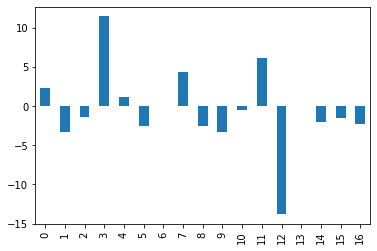

In [ ]:
#### Compare gains to Nifty 50 ####
nifty_raw = kite.historical_data(256265,extracted_data_df.time.iloc[-1],extracted_data_df.time.iloc[-1]+datetime.timedelta(days=60),'minute')
nifty_df = pd.DataFrame(nifty_raw)
nifty_gained_percent_in_60days =  100*(nifty_df.close.iloc[-1] - nifty_df.close[0])/nifty_df.close[0]
print(f'{nifty_gained_percent_in_60days=}')

this_telegram_channel_gained_percent_by_all_trades = extracted_data_df.gained_percent.sum()
print(f'{this_telegram_channel_gained_percent_by_all_trades=}')
outperforming_nifty_by_percentage = nifty_gained_percent_in_60days - this_telegram_channel_gained_percent_by_all_trades
print(f'{outperforming_nifty_by_percentage=}')
total_number_of_trades_done = 2*len(extracted_data_df.index)
print(f'{total_number_of_trades_done=}')

### Calculate compunded gains ####
init_percent = 100.0
list_map = []
for one_percent in extracted_data_df.gained_percent.tolist()[::-1]:
    init_percent = init_percent*((100+one_percent)/100)
    list_map.append({'init_percent':init_percent,'one_percent':one_percent})
#     print(one_percent)
compounded_gains = init_percent-100
print(f'{compounded_gains=}')
## GAINED PERCENTAGE TRADE-WISE ###
extracted_data_df['gained_percent'].plot.bar()

In [ ]:
final_percent_gain_df = pd.DataFrame(nest, nest_symbol_list).T
final_percent_gain_df

,RAYMOND,TRIGYN,GRANULES,TREJHARA,JMA,BLISSGVS,LIBERTSHOE,INDTERRAIN,CUBEXTUB,BALPHARMA,NIRAJ,BASML,ZODIACLOTH,KEYFINSERV,V2RETAIL
0,0.000000,-2.864816,0.000000,-0.422535,-1.383126,-0.728597,-1.376404,-0.891530,0.000000,-0.772798,-1.151316,-2.037618,-0.416667,0.000000,-1.496652
1,0.000000,-2.103850,0.000000,0.000000,0.000000,-0.667881,-1.460674,-1.411590,1.791531,-0.103040,0.000000,-1.959248,0.000000,0.041017,0.000000
2,0.190989,-2.417189,0.175523,0.492958,0.414938,-0.789314,-1.573034,-1.263001,0.814332,0.000000,-0.657895,-2.037618,0.104167,0.041017,-0.708941
3,0.190989,-2.596240,0.159566,0.845070,0.968188,-0.789314,0.000000,-1.040119,1.140065,-0.257599,-1.315789,-2.821317,0.312500,-0.246103,-1.299724
4,0.190989,-2.148612,0.111696,1.056338,1.936376,-0.850030,-0.196629,-1.040119,2.280130,0.566718,-1.315789,-2.429467,0.260417,-0.328138,-2.244978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,NaN,NaN,NaN,NaN,1.106501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5650,NaN,NaN,NaN,NaN,1.106501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5651,NaN,NaN,NaN,NaN,1.106501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5652,NaN,NaN,NaN,NaN,1.106501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
### add counter number at last in repeating column names
new_column_name_list = []
counter = 0
for one_name in final_percent_gain_df.keys().tolist():
    if(one_name not in new_column_name_list):
        new_column_name_list.append(one_name)
    else:
        new_column_name_list.append(one_name+'_'+str(counter))
        counter+=1
        
final_percent_gain_df.columns = new_column_name_list
final_percent_gain_df

,RAYMOND,TRIGYN,GRANULES,TREJHARA,JMA,BLISSGVS,LIBERTSHOE,INDTERRAIN,CUBEXTUB,BALPHARMA,NIRAJ,BASML,ZODIACLOTH,KEYFINSERV,V2RETAIL
0,0.000000,-2.864816,0.000000,-0.422535,-1.383126,-0.728597,-1.376404,-0.891530,0.000000,-0.772798,-1.151316,-2.037618,-0.416667,0.000000,-1.496652
1,0.000000,-2.103850,0.000000,0.000000,0.000000,-0.667881,-1.460674,-1.411590,1.791531,-0.103040,0.000000,-1.959248,0.000000,0.041017,0.000000
2,0.190989,-2.417189,0.175523,0.492958,0.414938,-0.789314,-1.573034,-1.263001,0.814332,0.000000,-0.657895,-2.037618,0.104167,0.041017,-0.708941
3,0.190989,-2.596240,0.159566,0.845070,0.968188,-0.789314,0.000000,-1.040119,1.140065,-0.257599,-1.315789,-2.821317,0.312500,-0.246103,-1.299724
4,0.190989,-2.148612,0.111696,1.056338,1.936376,-0.850030,-0.196629,-1.040119,2.280130,0.566718,-1.315789,-2.429467,0.260417,-0.328138,-2.244978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,NaN,NaN,NaN,NaN,1.106501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5650,NaN,NaN,NaN,NaN,1.106501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5651,NaN,NaN,NaN,NaN,1.106501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5652,NaN,NaN,NaN,NaN,1.106501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

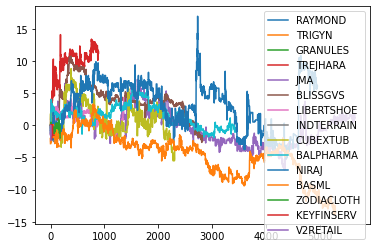

In [ ]:
final_percent_gain_df.plot()

# Listen to Telegram Channel for messages and predict tokens

In [ ]:
# Code from  https://python.plainenglish.io/telegram-channel-listener-with-python-8176ebe3c89b
import configparser
import json
import re
from telethon.errors import SessionPasswordNeededError
from telethon import TelegramClient, events, sync
from telethon.tl.functions.messages import (GetHistoryRequest)
from telethon.tl.types import (PeerChannel)

api_id = telegramAuth.api_id
api_hash = telegramAuth.api_hash
phone = telegramAuth.phone

user_input_channel = 'https://t.me/testchannelnottaken'

client = TelegramClient(phone, api_id, api_hash)

await client.connect()

if not await client.is_user_authorized():
    await client.send_code_request(phone)
    await client.sign_in(phone, input('Enter the code: '))
else :
    print('Autorised')

# Listen to messages from target channel 

@client.on(events.NewMessage()) 
async def newMessageListener(event):
    # Get message text 
    newMessage = event.message.message 
    classified_dict =  get_class_map_from_message_NEW(newMessage)
    print(classified_dict)
# #### GET FULL MESSAGE EVENT OBJECT in ASYNC MAnner #####
# @client.on(events.NewMessage)
# async def my_event_handler(event):
#     print('{}'.format(event))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Autorised


In [ ]:
##### Start Listening to Messages ########
async with client: 
    print('Now wating for new messages...')
    await client.run_until_disconnected() 

Now wating for new messages...
      sentence  sentence_class sentence_class_name
0                            0                    
1     INTRADAY               8            intraday
2            :               0                    
3          BUY               0                    
4   TRITURBINE              10              symbol
5        ABOVE               0                    
6          249               3               enter
7           SL               0                    
8          246               9                  sl
9       TARGET               0                    
10         255               5                exit
11           +               0                    


CancelledError: 

# Supplimentry Functions

In [ ]:
### JOIN CHANNEL FROM TELEGRAM CLIENT (not from telepot BOT) ####
# from telethon.tl.functions.channels import JoinChannelRequest
# await client(JoinChannelRequest('https://t.me/INTRADAY_001'))

#### TELEGRAM BOT #####
# import telepot
# bot_tkn = telegramAuth.bot_tkn
# bt1 = telepot.Bot(bot_tkn)
# response = bt1.getUpdates()
# print(response)

# #### GET FULL MESSAGE EVENT OBJECT in ASYNC MAnner #####
# @client.on(events.NewMessage)
# async def my_event_handler(event):
#     print('{}'.format(event))
# await client.start()
# await client.run_until_disconnected()